## Load libraries and data

In [226]:
import copy
import seaborn as sns
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import StackingClassifier
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV  

RANDOM_SEED = 8    # Set a random seed for reproducibility!

In [227]:
pd.set_option("display.max_columns", 100)

PATH = "Data/"

train_df = pd.read_csv(
    PATH + "train.csv", 
    index_col="PassengerId"
)
test_features_df = pd.read_csv(
    PATH + "test.csv", 
    index_col="PassengerId"
)

labels_df = train_df[['Survived']]
features_df = train_df.drop('Survived', axis=1)

labels_df.head()
features_df.head()
features_df.shape

(891, 10)

## Feature Enginnering

First we look at what are the numeric and catergorical columns in data

In [228]:
numeric_cols = features_df.columns[features_df.dtypes != 'object']
cat_cols = features_df.columns[features_df.dtypes == 'object']
print(numeric_cols, cat_cols)
features_df.head()

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object') Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [255]:
## Element vise operator functions
import re
def nameSplit(cabin):
    if isinstance(cabin, float):
        return cabin
    else:
        return cabin[0]
    
def idSplit(cabin):
    if isinstance(cabin, float):
        return cabin
    if isinstance(cabin, string_types):
        numbers = [int(s) for s in re.findall(r'-?\d+\.?\d*', cabin)]
        if len(numbers) > 0:
            return numbers[0]
        else:
            return np.nan

def ticketSplit(ticket):
    numbers = [float(s) for s in re.findall(r'-?\d+\.?\d*', ticket)]
    if len(numbers) > 0:
        return int(numbers[0])
    else:
        return np.nan

## column vise operators    
def namePrefix(dataFrame):
    new_df = copy.deepcopy(dataFrame)
    new_df["Name"] = dataFrame["Name"].apply(lambda x : "Mrs" if x.find("Mrs") != -1 
                                             else ("Miss" if x.find("Miss") != -1  
                                                          else "Mr"))
    return new_df

def separateCabin(dataFrame):
    new_df = copy.deepcopy(dataFrame)

    new_df["Cabin_L"] = dataFrame["Cabin"].apply(nameSplit)
    new_df["Cabin_N"] = dataFrame["Cabin"].apply(idSplit)
    new_df.drop('Cabin', inplace=True, axis=1)
    return new_df

def getTicketNumber(dataFrame):
    new_df = copy.deepcopy(dataFrame)
    new_df["Ticket"] = dataFrame["Ticket"].apply(ticketSplit)
    return new_df

separateCabinTransformer = FunctionTransformer(separateCabin)
namePrefixTransformer = FunctionTransformer(namePrefix)
ticketTransformer = FunctionTransformer(getTicketNumber)

getTicketNumber(features_df)
#namePrefix(features_df).head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,5.0,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,17599.0,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,2.0,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803.0,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450.0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536.0,13.0000,NaN,S
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053.0,30.0000,B42,S
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,6607.0,23.4500,NaN,S


In [291]:
total = features_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
Cabin,687.0,77.1
Age,177.0,19.9
Embarked,2.0,0.2
Fare,0.0,0.0
Ticket,0.0,0.0
Parch,0.0,0.0
SibSp,0.0,0.0
Sex,0.0,0.0
Name,0.0,0.0
Pclass,0.0,0.0


## Visualisation

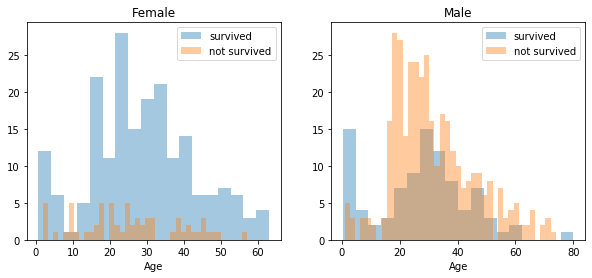

In [295]:
joined_df = features_df.join(labels_df)

survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = joined_df[train_df['Sex']=='female']
men = joined_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

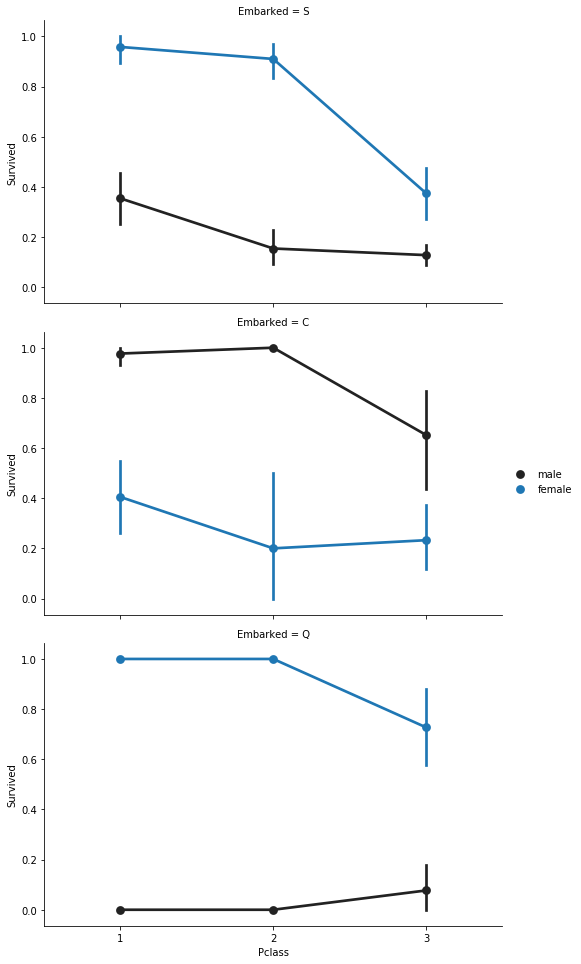

In [297]:
FacetGrid = sns.FacetGrid(joined_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

In [231]:
def plot_survive(col, target, data, ax=None):
    counts = (data[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

In [280]:
%matplotlib inline
import matplotlib.pyplot as plt

temp = separateCabin(features_df)
temp = namePrefix(temp)
temp = getTicketNumber(temp)
cols_to_plot = temp.columns[(temp.dtypes == 'object') | (temp.dtypes == 'int64')]
joined_df = temp.join(labels_df)
print(cols_to_plot)

Index(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_L'], dtype='object')


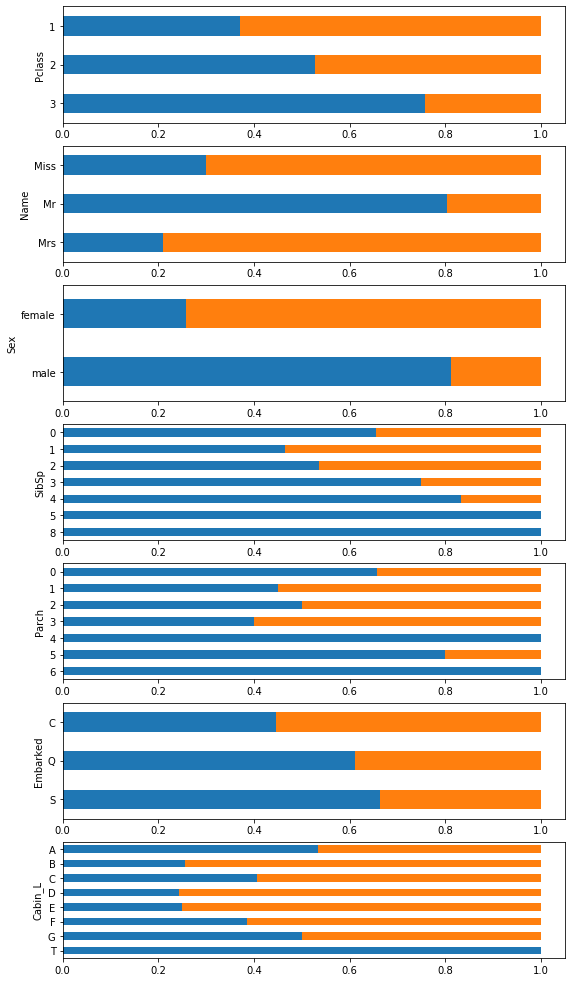

In [282]:
_, ax = plt.subplots(
    len(cols_to_plot), 1, figsize=(9,len(cols_to_plot)*2.5)
)

for idx, col in enumerate(cols_to_plot):
    plot_survive(
        col, 'Survived', joined_df, ax=ax[idx]
    )

In [283]:
# To compute correlation
#im = SimpleImputer(strategy='most_frequent')
#le = OrdinalEncoder()
#s1 = im.fit_transform(features_df[cat_cols])
#encoded = le.fit_transform(s1)

#encoded = pd.DataFrame(encoded, columns=cat_cols)

# join all the dataframe to compute correlations
#joined_df = features_df[numeric_cols].join(encoded).join(labels_df)
joined_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_L,Cabin_N,Survived
PassengerId,,,,,,,,,,,,
1,3,Mr,male,22.0,1,0,5.0,7.2500,S,NaN,NaN,0
2,1,Mrs,female,38.0,1,0,17599.0,71.2833,C,C,85.0,1
3,3,Miss,female,26.0,0,0,2.0,7.9250,S,NaN,NaN,1
4,1,Mrs,female,35.0,1,0,113803.0,53.1000,S,C,123.0,1
5,3,Mr,male,35.0,0,0,373450.0,8.0500,S,NaN,NaN,0


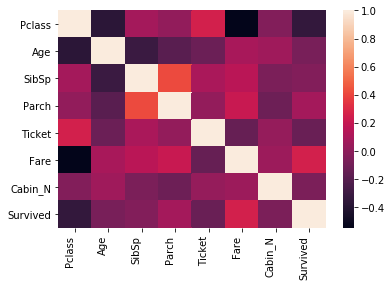

In [286]:
correlations = joined_df.corr()

ax = sns.heatmap(
    correlations
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [287]:
joined_df.describe()

,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin_N,Survived
count,891.000000,714.000000,891.000000,891.000000,8.870000e+02,891.000000,200.00000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,2.278464e+05,32.204208,50.49000,0.383838
std,0.836071,14.526497,1.102743,0.806057,5.024506e+05,49.693429,35.39497,0.486592
min,1.000000,0.420000,0.000000,0.000000,2.000000e+00,0.000000,2.00000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,1.177250e+04,7.910400,22.00000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,1.104130e+05,14.454200,43.00000,0.000000
75%,3.000000,38.000000,1.000000,0.000000,3.470625e+05,31.000000,77.25000,1.000000
max,3.000000,80.000000,8.000000,6.000000,3.101317e+06,512.329200,148.00000,1.000000


## Classifiers

In [168]:
est_mlp = MLPClassifier(hidden_layer_sizes=(200,100,), learning_rate='invscaling', learning_rate_init=0.01,
                          power_t=0.5, max_iter=500, shuffle=True, tol=0.0001, 
                          early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000,
                         random_state=RANDOM_SEED)
est_xgb = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, reg_lambda=30, reg_alpha=0)
est_gb = GradientBoostingClassifier(random_state=8, n_estimators=250)
est_rn = RandomForestClassifier(max_depth=10, bootstrap=True, n_estimators=200)
est_svc = SVC()
est_nb = GaussianNB()
est_kn = KNeighborsClassifier()

estimators_stacked = [('xbg', est_xgb),
              ('mlp', est_mlp),
             ]

stacked_estimator =  StackingClassifier(estimators=estimators_stacked,
                                    final_estimator=LogisticRegression(),
                                    stack_method='predict_proba'
                                  )

## Building the pipeline

In [202]:
seperate_processing_cols = ['Ticket']
cat_cols = [x for x in cat_cols if (x not in seperate_processing_cols)]
numeric_cols = [x for x in numeric_cols if (x not in seperate_processing_cols)]

print(numeric_cols, cat_cols)

numeric_preprocessing = Pipeline([
    ('Imputer', SimpleImputer()),
    ('Scaler', StandardScaler())
])

cat_preprocessing = Pipeline([
    ('name_transformer', namePrefixTransformer), 
    ('Cabin_transformer', separateCabinTransformer),
    ('Imputer', SimpleImputer(strategy='most_frequent')),
    ('Onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[('Numeric_preprocessing', numeric_preprocessing, numeric_cols),
                  ('Cat_preprocessing', cat_preprocessing, cat_cols)],
    remainder='drop'
)

full_pipeline = Pipeline([
    ('Preprocessor', preprocessor),
    ("estimator", est_mlp)
])

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'] ['Name', 'Sex', 'Cabin', 'Embarked']


## Training and Evaluation

In [203]:

#splitting the dataset
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)


full_pipeline.fit(X_train, y_train)
print("Training done")

C:\Users\pgunarathna\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training done


In [209]:
y_pred_train= full_pipeline.predict(X_train)
y_pred= full_pipeline.predict(X_eval)

In [210]:
accuracy_score(y_train, y_pred_train)

0.8640939597315436

In [211]:
accuracy_score(y_eval, y_pred)

0.823728813559322

In [212]:
%%time 

full_pipeline.fit(features_df, labels_df.values.ravel())

None   # So we don't print out the whole pipeline representation

Wall time: 690 ms


In [213]:
test_score = full_pipeline.predict(test_features_df)

In [215]:
y_preds = pd.DataFrame(
    {
        "Survived": test_score,
    },
    index = test_features_df.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (418, 1)


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [216]:
submission_df = pd.read_csv(PATH + "gender_submission.csv", 
                            index_col="PassengerId")

In [223]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)
# Save predictions to submission data frame
submission_df["Survived"] = test_score
submission_df.to_csv('my_submission.csv', index=True)